# Cell-type specific GRNs inference from PBMCs

## Step 1. Import packages

In [ ]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import itertools

### Set matplotlib setting

In [ ]:
plt.rc('font', family = "Times New Roman")
my_colors = ["#1EB2A6","#ffc4a3","#e2979c","#F67575"]
sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80, facecolor='white')# 设置输出图像格式

## Step 2. Read and preprocess the scRNA-seq data from PBMCs

... reading from cache file cache\C-Users-Administrator-Desktop-PBCM-GRCh38-matrix.h5ad
normalizing counts per cell
    finished (0:00:00)


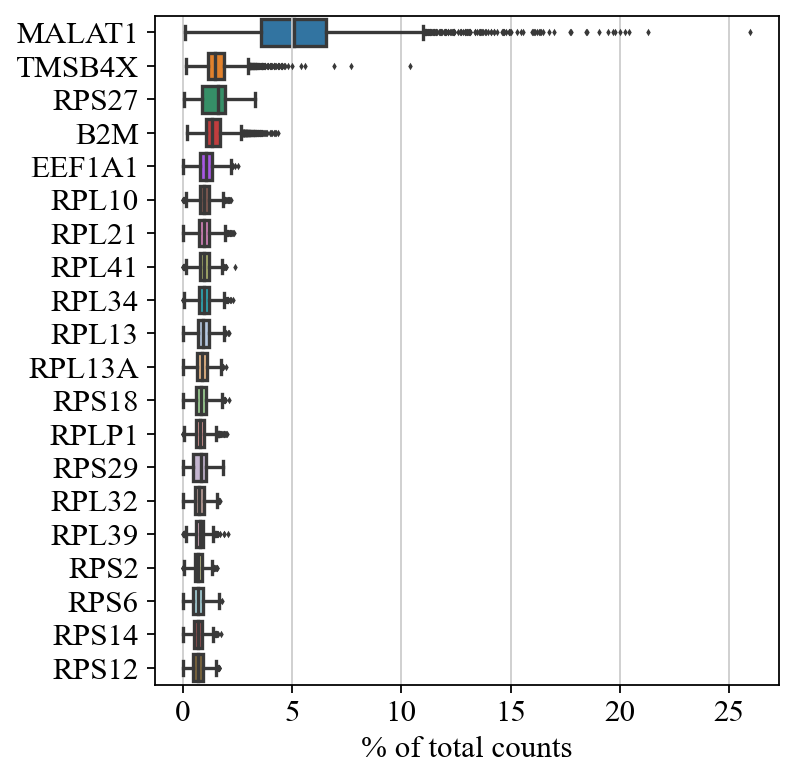

filtered out 15354 genes that are detected in less than 3 cells


In [ ]:
adata = sc.read_10x_mtx("C:/Users/Administrator/Desktop/PBCM/GRCh38/", var_names='gene_symbols', cache=True)
adata.var_names_make_unique()
adata
sc.pl.highest_expr_genes(adata, n_top=20)
sc.pp.filter_cells(adata, min_genes = 200)
sc.pp.filter_genes(adata, min_cells=3)

### Calculate the proportion of mitochondrial genes to all genes

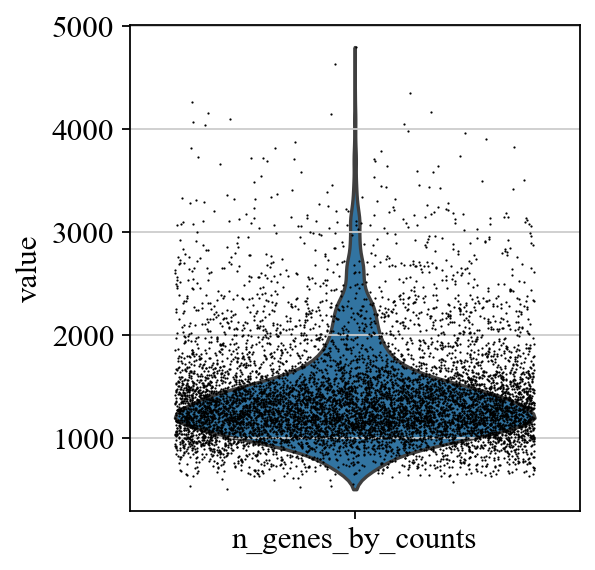

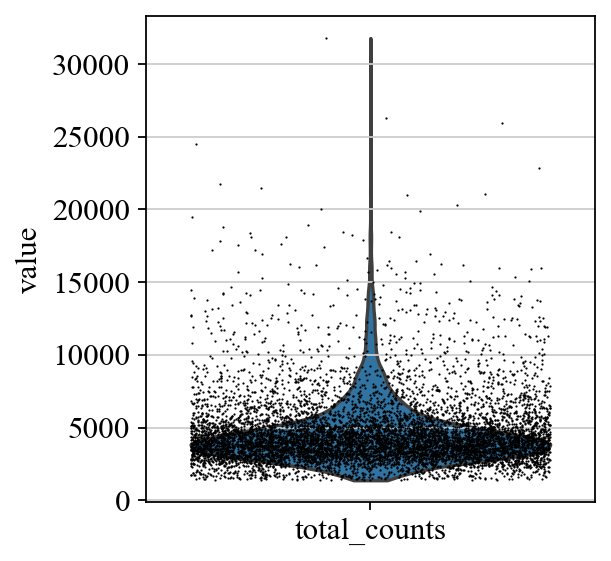

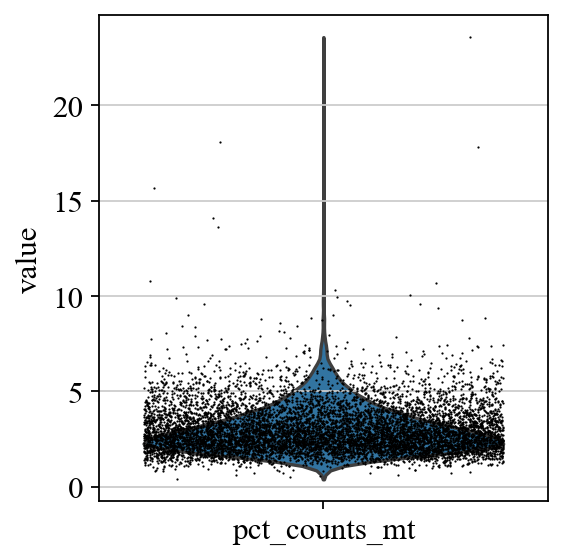

In [ ]:
adata.var_names[adata.var_names.str.match(r'^MT-')]
adata.var_names[adata.var_names.str.match(r'RP[SL0-9]')]
adata.var_names[adata.var_names.str.match(r'^ERCC-')]
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts'], jitter=0.4)
sc.pl.violin(adata, ['total_counts'], jitter=0.4)
sc.pl.violin(adata, ['pct_counts_mt'], jitter=0.4)

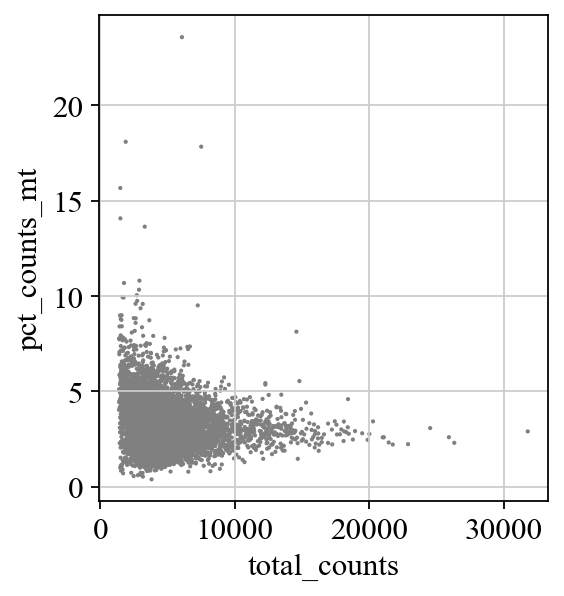

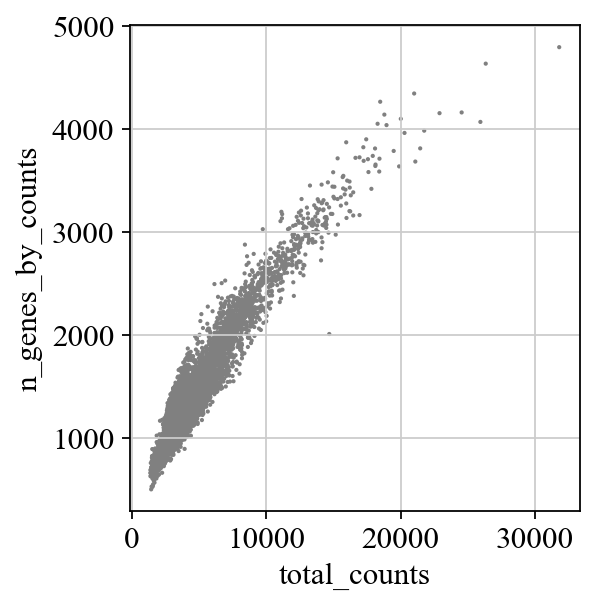

In [ ]:
sc.pl.scatter(adata, x = 'total_counts', y = 'pct_counts_mt')
sc.pl.scatter(adata, x = 'total_counts', y = 'n_genes_by_counts')

### Filtration

In [ ]:
adata = adata[adata.obs.pct_counts_mt < 8, :]
adata = adata[adata.obs.n_genes_by_counts < 4000, :]

### Normalization

normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes


d:\conda\envs\tf2.4\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


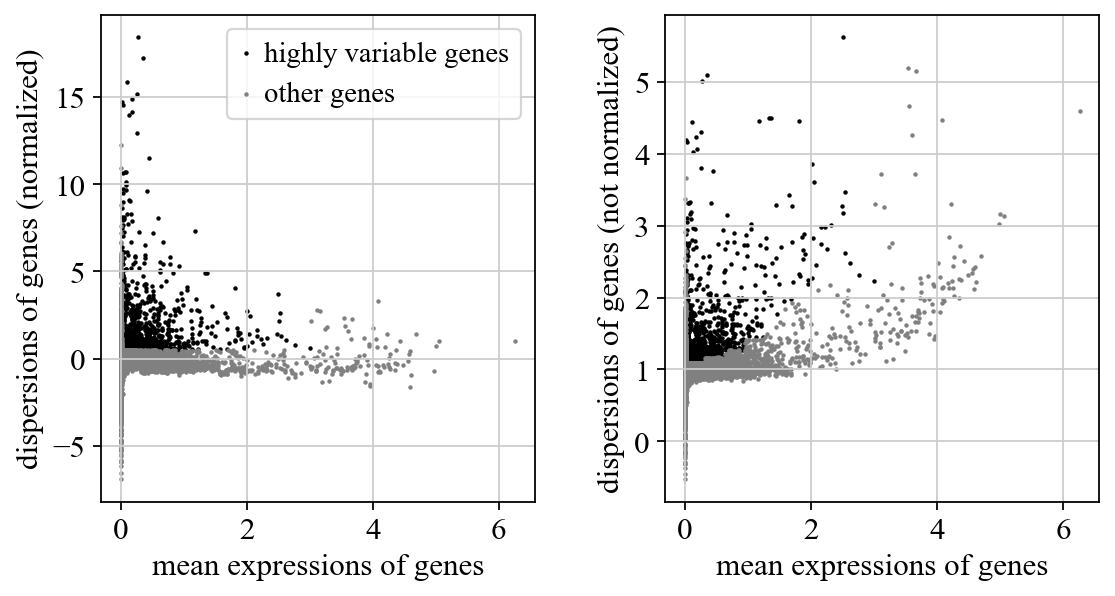

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp = 0.5)
sc.pl.highly_variable_genes(adata)

### Perfrom PCA to reduce the dimension using highly variable genes

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


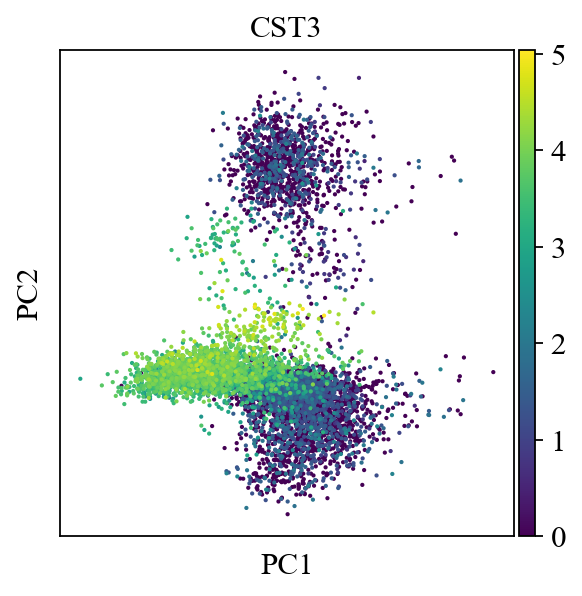

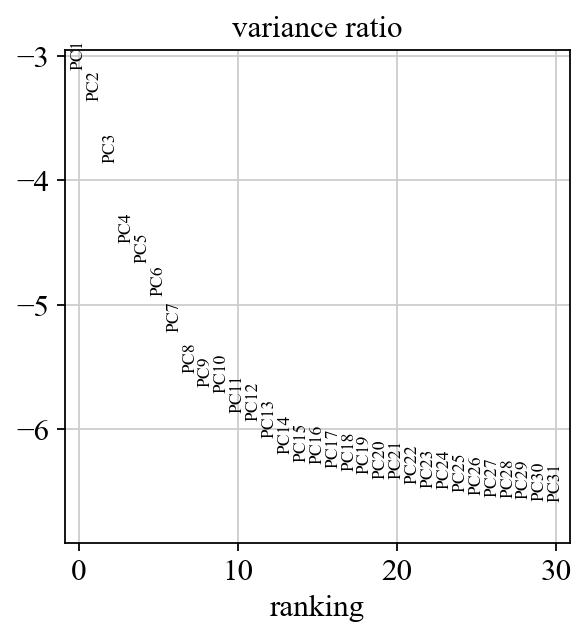

In [8]:
adata.raw = adata
adata = adata[:, adata.var.highly_variable]
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value = 10)
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color = 'CST3')
sc.pl.pca_variance_ratio(adata, log = True)

## Step 3. Clustering analysis by leiden and visualization by TSNE

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE


d:\conda\envs\tf2.4\lib\site-packages\sklearn\manifold\_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:19)


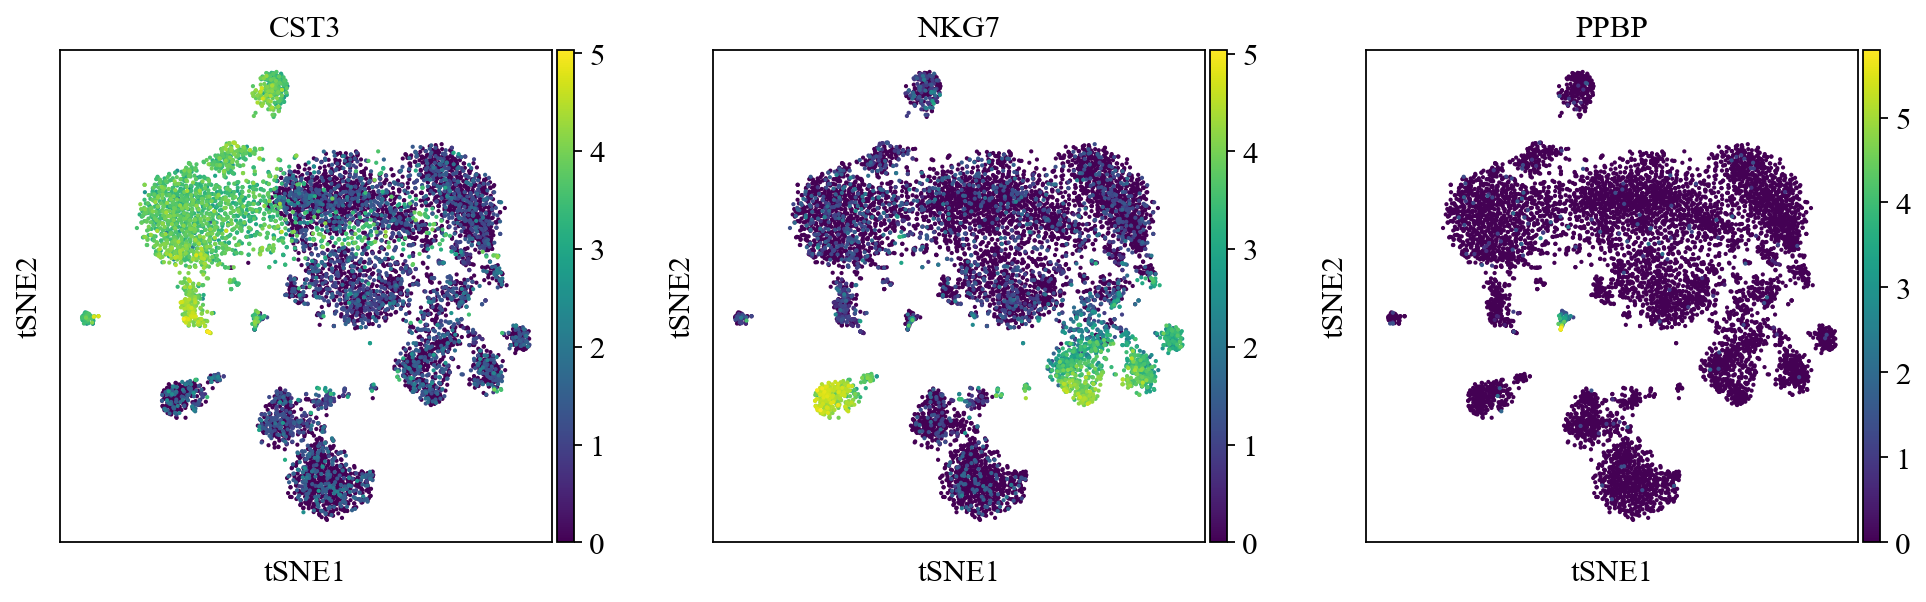

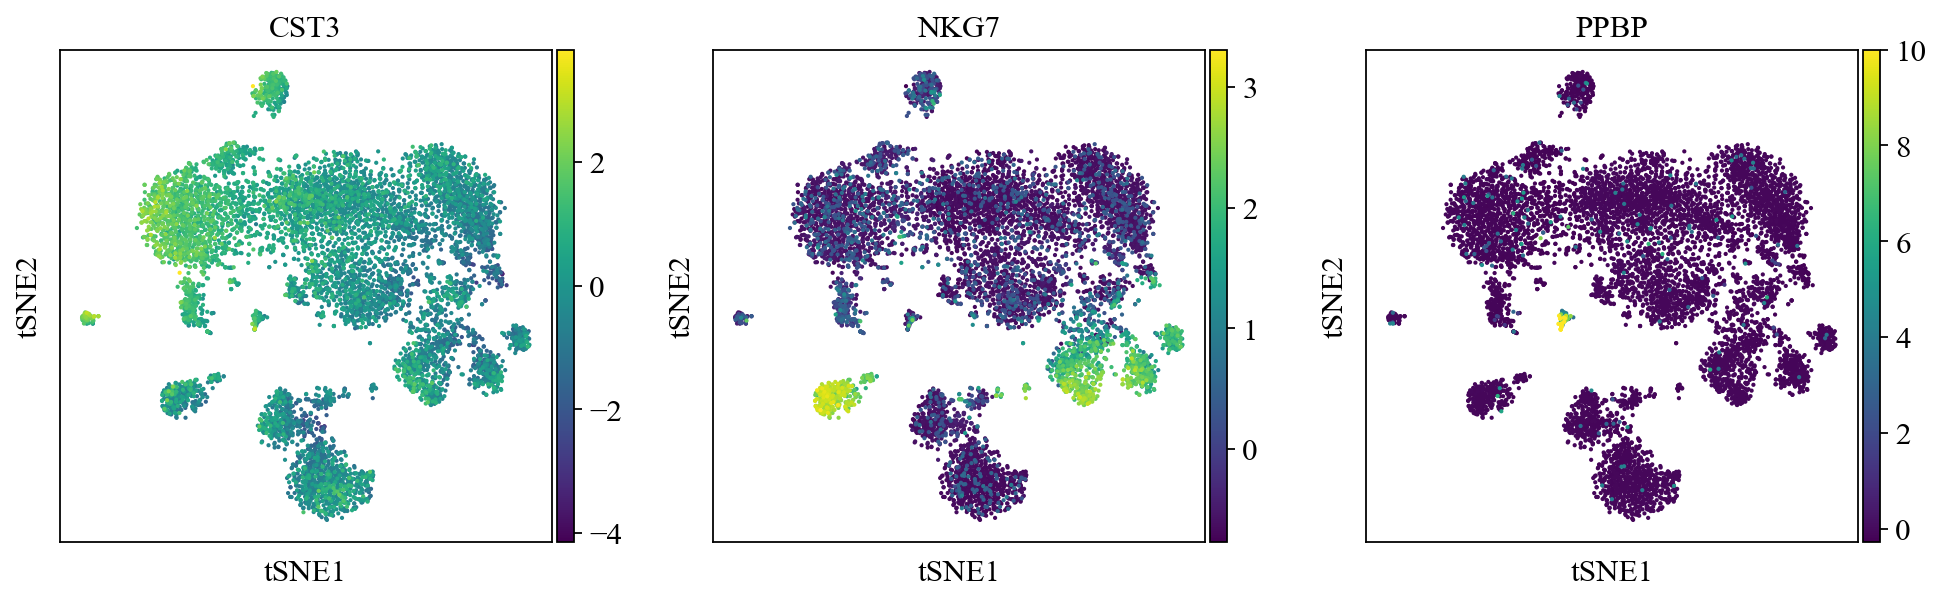

In [10]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.tsne(adata)
sc.pl.tsne(adata, color = ['CST3', 'NKG7', 'PPBP'])
sc.pl.tsne(adata, color = ['CST3', 'NKG7', 'PPBP'], use_raw=False)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
running Leiden clustering
    finished: found 21 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


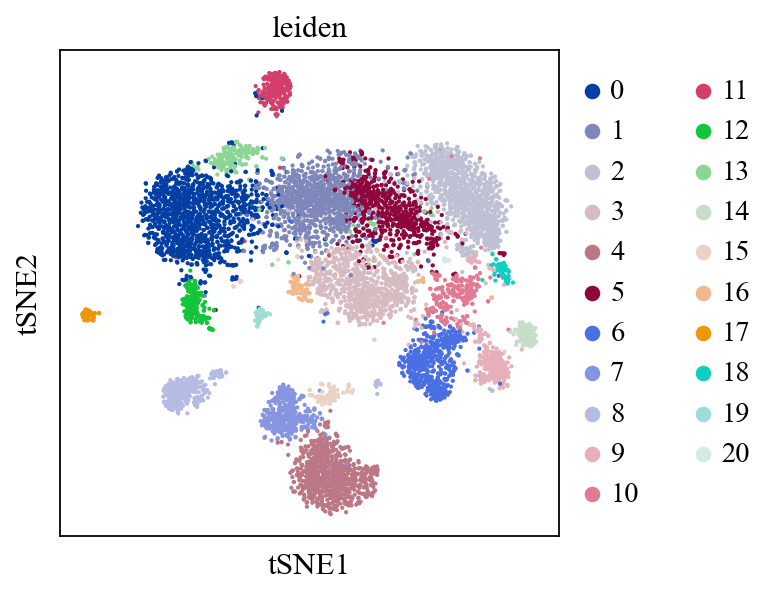

In [11]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.leiden(adata)
sc.pl.tsne(adata, color = 'leiden')

### Find marker genes for cell population annotation

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


d:\conda\envs\tf2.4\lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
d:\conda\envs\tf2.4\lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider using pd.concat instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
d:\conda\envs\tf2.4\lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

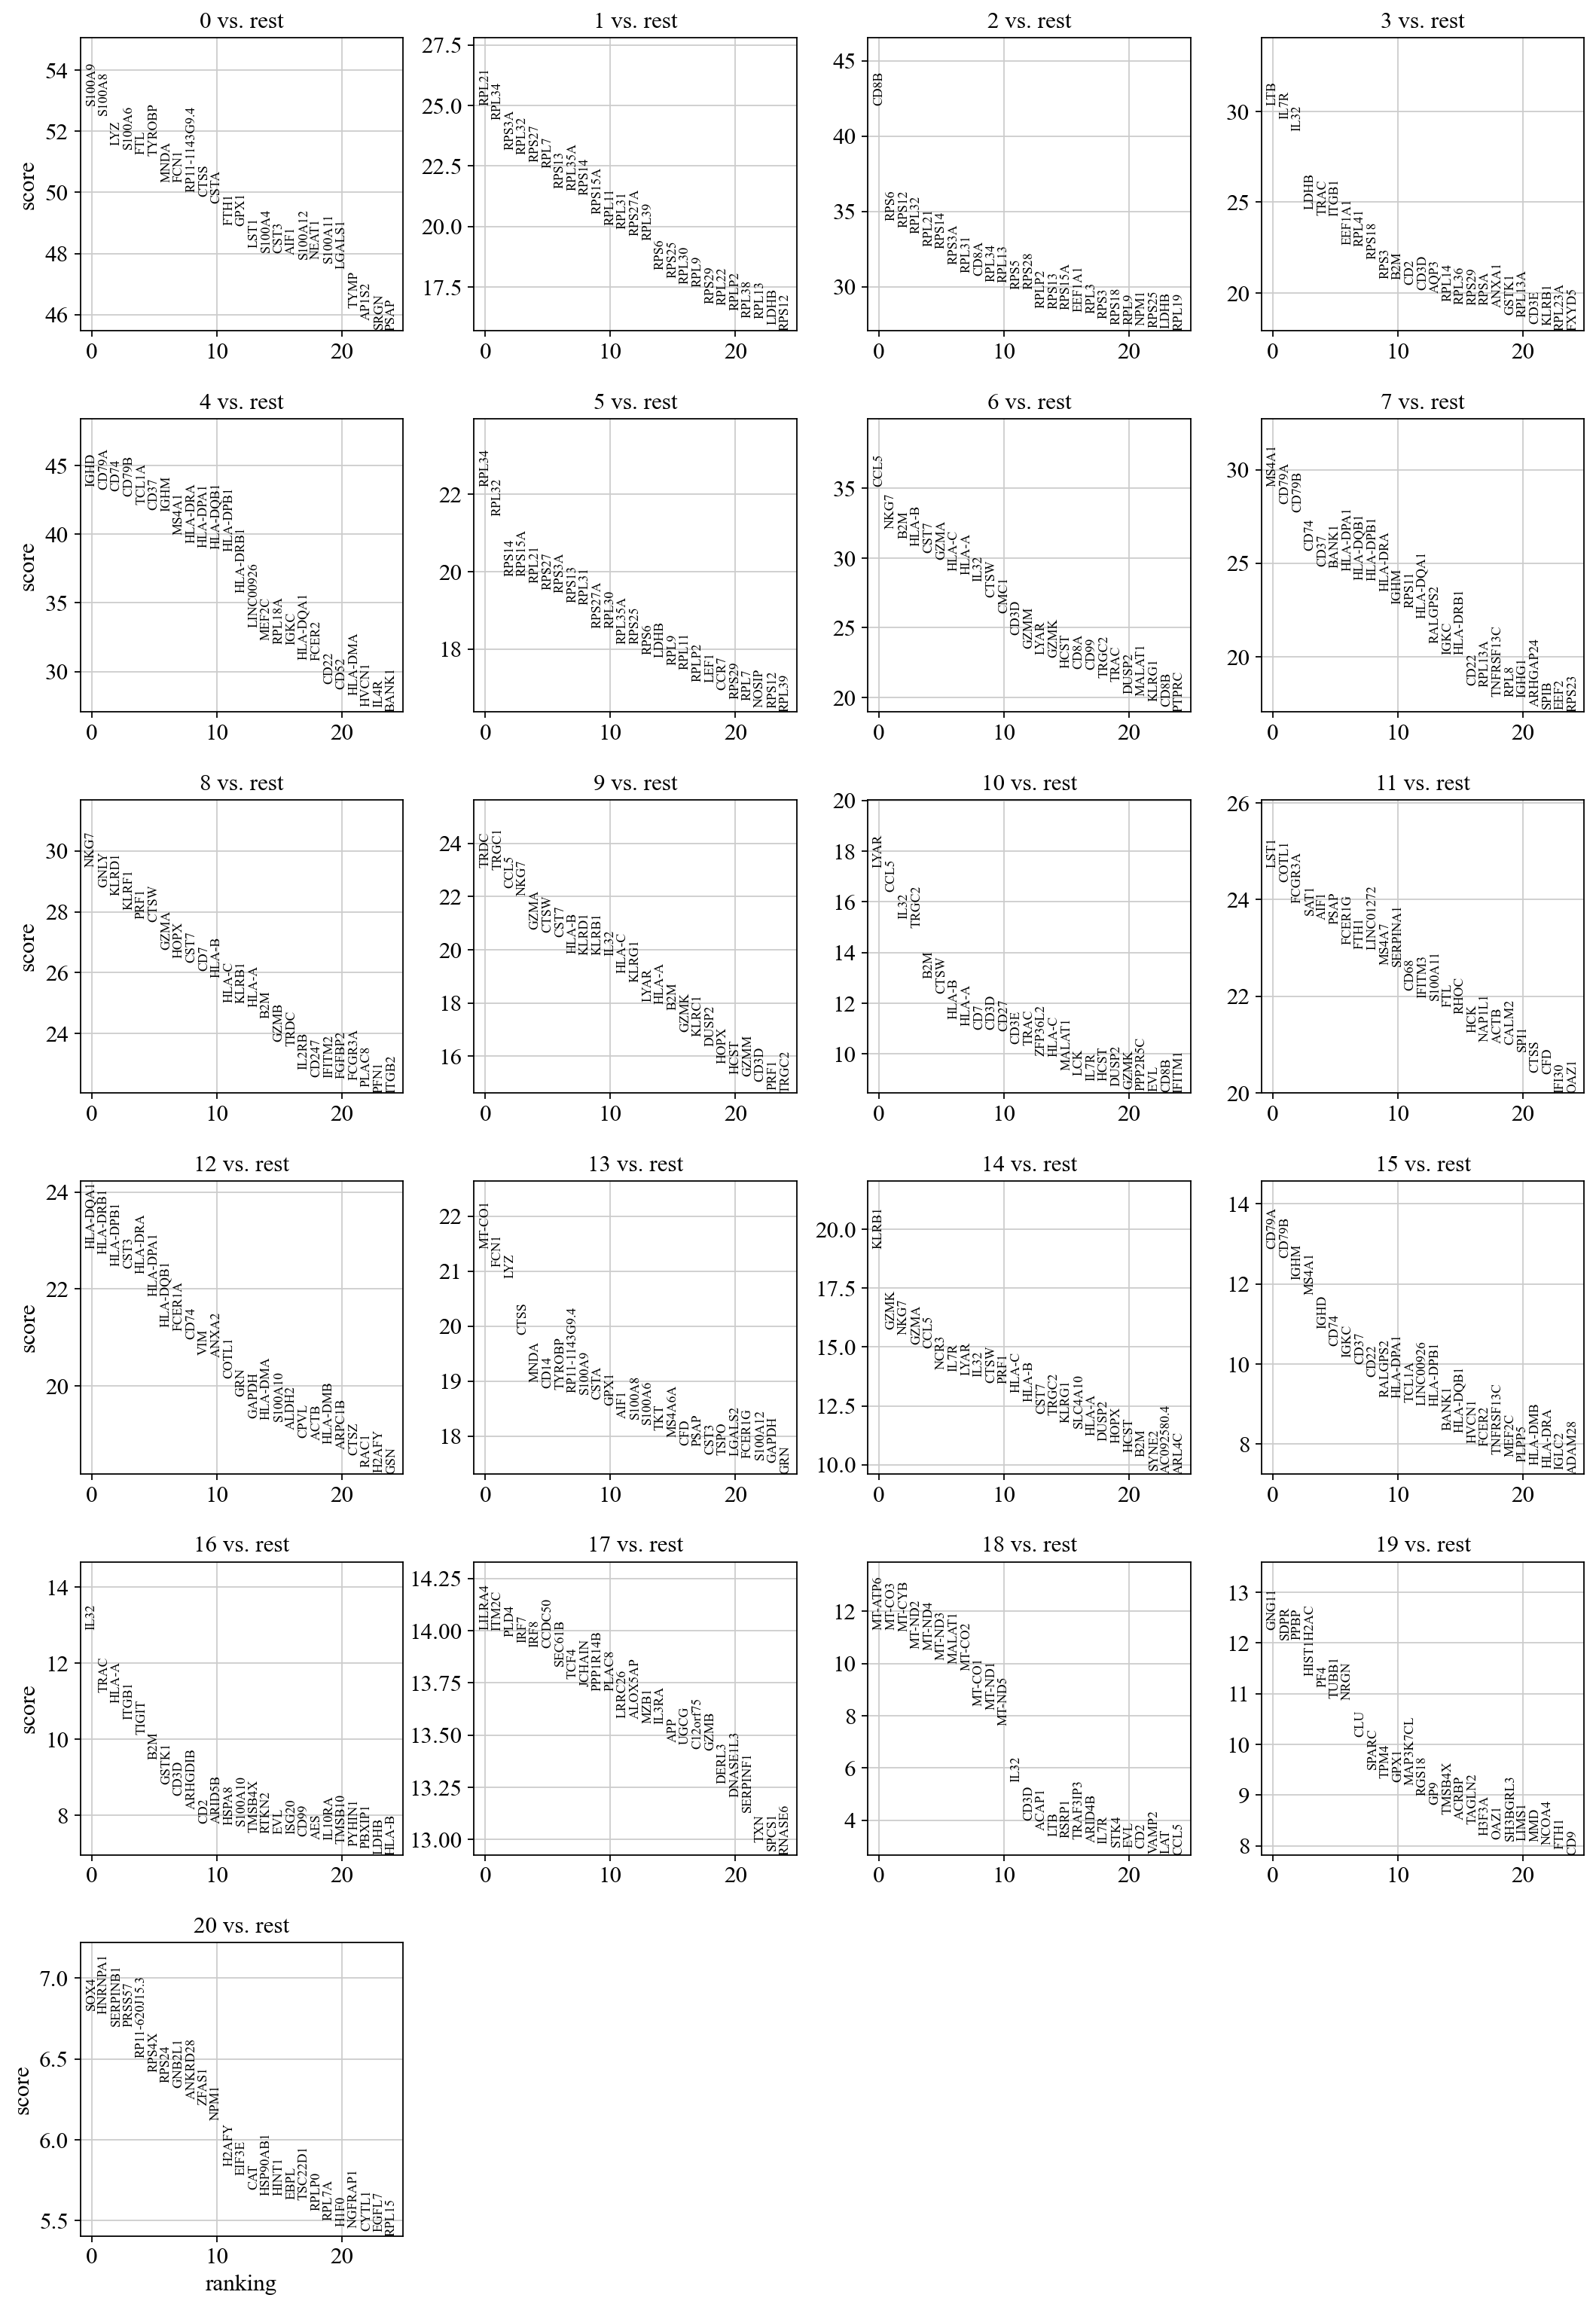

In [12]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [13]:
num = 2
marker_genes = list(set(np.array(pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(num)).reshape(-1)))
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '-' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).iloc[0:6, 0:6]

,0-n,0-p,1-n,1-p,2-n,2-p
0,S100A9,0.0,RPL21,5.819645e-138,CD8B,0.000000e+00
1,S100A8,0.0,RPL34,1.080242e-131,RPS6,2.156718e-259
2,LYZ,0.0,RPS3A,8.031232e-119,RPS12,2.322017e-252
3,S100A6,0.0,RPL32,5.382723e-117,RPL32,5.700781e-247
4,FTL,0.0,RPS27,6.392157e-114,RPL21,1.761806e-234
5,TYROBP,0.0,RPL7,2.135135e-111,RPS14,3.901650e-232


In [14]:
result_file = 'C:/Users/Administrator/Desktop/PBCM/pbmc8k.h5ad'

In [15]:
adata.write(result_file)

### Select the top-four cell types with large number of cells

In [16]:
adata.obs['leiden'].value_counts()

0     1295
1      957
2      955
3      845
4      770
5      650
6      524
7      373
8      319
9      275
10     244
11     220
12     194
13     193
14     129
15     108
16      91
17      66
18      59
19      55
20      17
Name: leiden, dtype: int64

In [17]:
clus0 = adata[adata.obs['leiden'].isin(['0']),:]
clus0.write('C:/Users/Administrator/Desktop/PBCM/CD14Monocyte.h5ad')

In [18]:
clus1 = adata[adata.obs['leiden'].isin(['1','5']), :]
clus1.write('C:/Users/Administrator/Desktop/PBCM/CD4T.h5ad')

In [19]:
clus2 = adata[adata.obs['leiden'].isin(['2']),:]
clus2.write('C:/Users/Administrator/Desktop/PBCM/CD8T.h5ad')

In [20]:
clus3 = adata[adata.obs['leiden'].isin(['4']),:]
clus3.write('C:/Users/Administrator/Desktop/PBCM/BC.h5ad')

## Step 4. Using ZINB_GRAN to perform cell-type specific GRN inference.

In [21]:
import os
os.chdir(os.getcwd())
import sys
sys.path.append("C:/Users/Administrator/Desktop/单细胞2/ZINB_GRAN-main原")
import tensorflow.compat.v1 as tf
import numpy as np
import pandas as pd
from train import *
from util.utils import div_list
import time
from evaluate import evaluateAU, evaluateEPR, evaluateAUPRratio

### Read the ground truth

In [22]:
refNetwork = pd.read_csv("C:/Users/Administrator/Desktop/PBCM/GARNet_results/CD14Monocyte-TF_Target_Pairs1.csv", header = 0)

### Cell-type specific GRNs inferring

In [23]:
flags = tf.flags
FLAGS = flags.FLAGS
flags.DEFINE_string('f', '', "kernel")
flags.DEFINE_string('model', 'ZINB_GRAN', 'Model string.')
flags.DEFINE_float('learning_rate', 0.001, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 500, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 200, 'Number of units in hidden layer 1.')
flags.DEFINE_float('dropout', 0.7, 'Dropout rate (1 - keep probability).')
flags.DEFINE_float('weight_decay', 1e-4, 'Weight for L2 loss on embedding matrix.')
flags.DEFINE_integer('early_stopping', 10, 'Tolerance for early stopping (# of epochs).')
flags.DEFINE_integer('max_degree', 3, 'Maximum Chebyshev polynomial degree.')
flags.DEFINE_integer('ratio', 1, 'Ratio of negetive samples to positive samples.')
flags.DEFINE_integer('dim', 300, 'The size of latent factor vector.')

#pbmc_4clus = [clus0, clus1, clus2, clus3]
#pbmc_4clus_name = ["CD4 T", "CD14 Monocyte", "CD8 T", "B"]
pbmc_4clus = [clus1]
pbmc_4clus_name = ["CD14 Monocyte"]

for k in range(1):
    clus = pbmc_4clus[k]
    labels = []
    data=pd.read_csv("C:/Users/Administrator/Desktop/PBCM/CD14_gene_expression筛选.csv",header=0, index_col=0)
    data = data.T
    # 保留 clus.var_names，统一大写
    #var_names = [gene.upper() for gene in clus.var_names]
    var_names = [gene.upper() for gene in data.columns]
    var_index_map = {gene: idx for idx, gene in enumerate(var_names)}

    num_genes = len(var_names)
    AM = np.zeros([num_genes, num_genes])

    # 构建邻接矩阵和标签
    for row_index, row in refNetwork.iterrows():
        gene1, gene2 = row[0].upper(), row[1].upper()
        if gene1 in var_index_map and gene2 in var_index_map:
            idx1, idx2 = var_index_map[gene1], var_index_map[gene2]
            AM[idx1, idx2] = 1
            labels.append([idx1, idx2, 1])
        else:
            print(f"Skipping unmatched genes: {gene1}, {gene2}")
    labels = np.array(labels)

    # 打印调试信息
    #print(f"AM shape: {AM.shape}, Labels shape: {labels.shape}")
    print(f"Labels type: {type(labels)}, shape: {labels.shape}")
    print(f"AM type: {type(AM)}, shape: {AM.shape}")
    #print(f"Var_names length: {len(var_names)}")

    # 计算相关性矩阵
    #data = pd.DataFrame(clus.X)
    corr = data.corr(method='spearman')
    corr.values[corr.values < 0.0] = 0.0
    adj = np.array(corr.values)
    TF = set(refNetwork['Gene1'])

    # 交叉验证
    reorder = np.arange(labels.shape[0])
    np.random.shuffle(reorder)
    cv = 3
    order = div_list(reorder.tolist(), cv)
    
    pred_results = []
    for i in range(cv):
        print("Cross validation:", '%01d' % (i))
        result_path_cv = f"C:/Users/Administrator/Desktop/PBCM/results/result_path_{pbmc_4clus_name[k]}_cv{i}.csv"
        test_arr = order[i]
        arr = list(set(reorder).difference(set(test_arr)))
        np.random.shuffle(arr)
        train_arr = arr
        AM = np.array(AM)
        #node_feat = adata.X.T
        node_feat = data.T.to_numpy()  # 转换为 numpy 数组
        print(f"node_feat type: {type(node_feat)}, shape: {node_feat.shape}")
        print(f"AM type: {type(AM)}, shape: {AM.shape}")
        # 调用 train 函数
        pred_matrix = train(FLAGS, adj,node_feat, train_arr, test_arr, labels, AM, var_names, TF, result_path_cv)
        #(FLAGS, adj, features, train_arr, test_arr, labels, AM, gene_names, TF, result_path)
        pred_results.append(pred_matrix)

    output = pred_results[0]
    for j in range(1, 3):
        output = pd.concat([output, pred_results[j]])
    output['EdgeWeight'] = abs(output['EdgeWeight'])
    output.groupby(['Gene1', 'Gene2']).mean()
    output.to_csv('C:/Users/Administrator/Desktop/PBCM/results/Inferred_GRNs_' + pbmc_4clus_name[k] + '.csv', header=True, index=False)


Labels type: <class 'numpy.ndarray'>, shape: (2281, 3)
AM type: <class 'numpy.ndarray'>, shape: (515, 515)
Cross validation: 0
node_feat type: <class 'numpy.ndarray'>, shape: (515, 1295)
AM type: <class 'numpy.ndarray'>, shape: (515, 515)
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch: 0001 train_loss= 8.20468 train_acc= -7.17288 time= 0.06597
Epoch: 0002 train_loss= 6.77972 train_acc= -5.74832 time= 0.02802
Epoch: 0003 train_loss= 4.91572 train_acc= -3.88468 time= 0.02869
Epoch: 0004 train_loss= 4.21160 train_acc= -3.18089 time= 0.02800
Epoch: 0005 train_loss= 3.47869 train_acc= -2.44828 time= 0.02798
Epoch: 0006 train_loss= 2.99014 train_acc= -1.96001 time= 0.02800
Epoch: 0007 train_loss= 2.55988 train_acc= -1.53002 time= 0.02802
Epoch: 0008 train_loss= 2.30370 train_acc= -1.27409 time= 0.02798
Epoch: 0009 train_loss= 2.24351 train_acc= -1.21415 time= 0.03003
Epoch: 0010 train_loss= 1.97111 train_acc= -0.94198 